# Importing relevant libraries

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard

import itertools
from pprint import pprint
from scipy.interpolate import interp1d
import scipy as sp
from sklearn import preprocessing

import math
import plotly.express as px
from pathlib import Path

objc[31768]: Class CaptureDelegate is implemented in both /Users/yannick/opt/anaconda3/envs/test-env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x15127a4d0) and /Users/yannick/opt/anaconda3/envs/test-env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x151a0c860). One of the two will be used. Which one is undefined.
objc[31768]: Class CVWindow is implemented in both /Users/yannick/opt/anaconda3/envs/test-env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x15127a520) and /Users/yannick/opt/anaconda3/envs/test-env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x120114a68). One of the two will be used. Which one is undefined.
objc[31768]: Class CVView is implemented in both /Users/yannick/opt/anaconda3/envs/test-env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x15127a548) and /Users/yannick/opt/anaconda3/envs/test-env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x120114a90). One of the two w

### Defining our used Subset of the dataset

In [2]:
words =  np.array(['hvad', 'ja', 'soed'])

label_map = {label:num for num, label in enumerate(words)}

## Importing saved data and setting up Train and Test data arrays

In [3]:
# Keypoint_list_of_arrays is a python list containing "video amount" of NP arrays.
# Each array inside the list has size  
keypoint_list_of_arrays = []
labels = []
vid_frames = []
for word in words:
    dir_path = "tegn_subset/" + str(word) + "_data" + "/"
    for vid_folder in next(os.walk(dir_path))[1]:
        # Finds number of .npy files in current vid_folder
        frame_len = len([entry for entry in os.listdir(dir_path + str(vid_folder)) 
                        if entry.endswith('.npy') and os.path.isfile(os.path.join(dir_path + str(vid_folder), entry))])
        vid_frames.append(frame_len)
        tmp = []
        for frame_num in range(frame_len):
            imported_data = np.load(os.path.join(dir_path, vid_folder, word) + str(frame_num) + ".npy")
            tmp.append(imported_data)

        tmp = np.array(tmp)
        #print(tmp.shape)

        keypoint_list_of_arrays.append(tmp)
        labels.append(label_map[word])

max(vid_frames)


151

# Interpolating Keypoints

Extracting specific coordinates for right hand, left hand and pose from previously appended data.

Meaning our first $33*4$ out of 258 values are for pose, the next $21*3$ are for left_hand and the last $21*3$ are for right_hand.
We now want to seperate all coordinates and visibility values such that it is easy for us to access all specific coordinates 
for a single keypoint for all frames. 

We will then proceed to interpolate values for all coordinates 

In [4]:
# As input array HAS to be of size (frame_amount, 258)
def split_array(array_to_split):
    # Splits total array into pose values and hand values 
    posearr = array_to_split[:, 0:132]
    handarr = array_to_split[:, 132::]

    # Splititng handarr to seperate left hand from right hand values
    splithandarr = np.split(handarr, 2, axis=1)
    lhcoords = splithandarr[0]
    rhcoords = splithandarr[1]

    # Extracting specific coordinates for both the left and right hand
    rhxcoords = rhcoords[:, 0::3]
    lhxcoords = lhcoords[:, 0::3]

    rhycoords = rhcoords[:, 1::3]
    lhycoords = lhcoords[:, 1::3]

    rhzcoords = rhcoords[:, 2::3]
    lhzcoords = lhcoords[:, 2::3]

    # Splitting up coordinates and visibility values for pose
    pxcoords = posearr[:, 0::4]
    pycoords = posearr[:, 1::4]
    pzcoords = posearr[:, 2::4]
    pvis = posearr[:, 3::4]

    return pxcoords, pycoords, pzcoords, pvis, lhxcoords, lhycoords, lhzcoords, rhxcoords, rhycoords, rhzcoords

# With this splitting it seems that every row (out of 48 total) now contains all x coordinates for one frame for BOTH hands
# This means that to get all sequential x coordinates for one specific point we can take each column. 
# So column handxcoord[:, 0] is 

t = split_array(keypoint_list_of_arrays[0])


### Filtering for removal of outliars



In [5]:
from scipy.signal import butter,filtfilt
import plotly.graph_objects as go
fs = 20.0 # sample rate, Hz
cutoff = 2 # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
order = 2 # sin wave can be approx represented as quadratic

# Taken from https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (0.5 * fs)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

y = butter_lowpass_filter(t[6][:,0], cutoff, fs, order)

fig = go.Figure()
fig.add_trace(go.Scatter(
            y = t[5][:,0],
            line =  dict(shape =  'spline' ),
            name = 'signal with noise'
            ))
fig.add_trace(go.Scatter(
            y = y,
            line =  dict(shape =  'spline' ),
            name = 'filtered signal'
            ))
fig.show()


### Interpolating new keypoint using all sequential data for a single keypoint coordinate through all frames

In [6]:
def interpolate_frames(keypoint_data, current_frames, max_frames):
    # Calculate x and y values to be able to plot it later, furthermore also used for interpolation
    x = range(0,current_frames)
    y = keypoint_data

    if (current_frames != max_frames):
        new_x = np.linspace(0, current_frames-1, max_frames, endpoint=False)
        new_y = sp.interpolate.interp1d(x, y, kind='cubic')(new_x)
    else:
        return y
    # Plot the results
    # plt.figure()
    # plt.subplot(2,1,1)
    # plt.plot(x, y, 'bo-')
    # plt.title('Using 1D Cubic Spline Interpolation')

    # plt.subplot(2,1,2)
    # plt.plot(new_x, new_y, 'ro-')

    # plt.show()
    
    return new_y


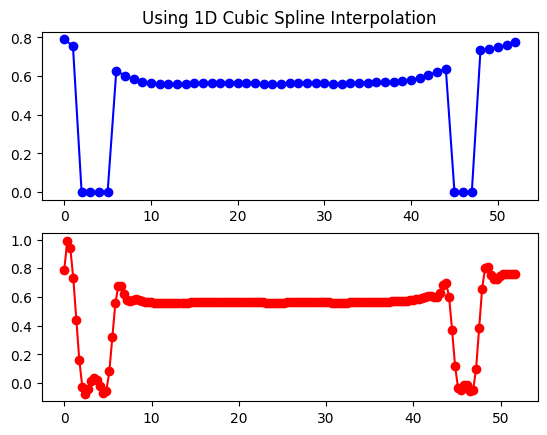

In [194]:
# This takes t[5] as input which is our rhxcoords array outputtet as a test earlier 
test = interpolate_frames((t[5])[:,0],  t[5].shape[0], max(vid_frames))

In [7]:
def full_data_interpolation(data_array_list):
    interpolated_list = []
    for i in range(len(data_array_list)):
        split_data = split_array(data_array_list[i])
        tmp = []
        for coords in range(len(split_data)):
            coord_array = split_data[coords]
            for col in range(coord_array.shape[1]):
                normalized_data = preprocessing.normalize(coord_array[:, col].reshape(-1,1), axis=0).ravel()
                filtered_data = butter_lowpass_filter(normalized_data, cutoff, fs, order)
                interpolated_data = interpolate_frames(filtered_data,  filtered_data.shape[0], max(vid_frames))
                tmp.append(interpolated_data)

        interpolated_list.append((np.array(tmp)).T)
    return np.array(interpolated_list)

interpolated_list = full_data_interpolation(keypoint_list_of_arrays)
interpolated_list.shape

(66, 151, 258)

### Creating Training and Testing set

In [24]:
X = np.array(interpolated_list)
y = to_categorical(labels).astype(int)

print(X.shape)
print(y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=18, stratify=y)
print(np.count_nonzero(y_test[:,0]))
print(np.count_nonzero(y_test[:,1]))
print(np.count_nonzero(y_test[:,2]))

(66, 151, 258)
(66, 3)
5
6
7


# LSTM Neural Network Implementation

### Saving NN Logs

In [151]:
tracing_logs = TensorBoard(os.path.join('Logs'))

### NN Implementation

In [180]:

model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(142,258)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(32, return_sequences=False, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(words.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Testing NN prediction accuracy

In [13]:
_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5


def plot_landmarks(landmark_list, connections=None, ):
    if not landmark_list:
        return
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if (
            landmark.HasField("visibility")
            and landmark.visibility < _VISIBILITY_THRESHOLD
        ) or (
            landmark.HasField("presence") and landmark.presence < _PRESENCE_THRESHOLD
        ):
            continue
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    if connections:
        out_cn = []
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f"Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx],
                    plotted_landmarks[end_idx],
                ]
                out_cn.append(
                    dict(
                        xs=[landmark_pair[0][0], landmark_pair[1][0]],
                        ys=[landmark_pair[0][1], landmark_pair[1][1]],
                        zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    )
                )
        cn2 = {"xs": [], "ys": [], "zs": []}
        for pair in out_cn:
            for k in pair.keys():
                cn2[k].append(pair[k][0])
                cn2[k].append(pair[k][1])
                cn2[k].append(None)

    df = pd.DataFrame(plotted_landmarks).T.rename(columns={0: "z", 1: "x", 2: "y"})
    df["lm"] = df.index.map(lambda s: mp_holistic.PoseLandmark(s).name).values
    fig = (
        px.scatter_3d(df, x="z", y="x", z="y", hover_name="lm")
        .update_traces(marker={"color": "red"})
        .update_layout(
            margin={"l": 0, "r": 0, "t": 0, "b": 0},
            scene={"camera": {"eye": {"x": 2.1, "y": 0, "z": 0}}},
        )
    )
    fig.add_traces(
        [
            go.Scatter3d(
                x=cn2["xs"],
                y=cn2["ys"],
                z=cn2["zs"],
                mode="lines",
                line={"color": "black", "width": 5},
                name="connections",
            )
        ]
    )

    return fig

In [109]:
vid_path = 'test.mp4'

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic_model:
    vid_file = cv2.VideoCapture(vid_path)
    num_frames = int(vid_file.get(cv2.CAP_PROP_FRAME_COUNT))
    tmp = []
    # Loop through video length aka sequence length
    for frame in range(num_frames):
        ret, frame = vid_file.read()
        image, results = process_image(frame, holistic_model)
        
        #test = plot_landmarks(results.pose_world_landmarks,  mp_holistic.POSE_CONNECTIONS)
        
        keypoints = extract_keypoints(results)
        tmp.append(keypoints)
    
    input_testing = [np.asarray(tmp)]

    testing_data = full_data_interpolation(input_testing)
    print(testing_data.shape)
       
    vid_file.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)
test

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


(1, 151, 258)


NameError: name 'test' is not defined